In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import os

import plotly.express as px
import plotly.graph_objects as go
from plotly.io import renderers
renderers.default = 'notebook'

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [19]:
def simulate_data_from_polynomial_w_noise(poly_degree=3, sample_size=300, min_x = 0, max_x=100,
                                        y_range_max=100, noise_mean=0, noise_var=10):
    """ 
    Creates a polynomial of degree `poly_degree` that has roots between min_x and max_x
    and a range limited to [-y_range_max, y_range_max]. Then samples data points between
    min_x and max_x and returns a dataframe of that data with noise added of mean `noise_mean`
    and variance `noise_var`
    """


    # Generate random roots between min_x and max_x
    random_roots = np.random.uniform(min_x, max_x, size=poly_degree)
    sorted_roots = np.sort(random_roots)  # Sort roots for spacing
    roots = [sorted_roots[0]]  # Start with the first root

    # Create min root spacing
    min_spacing = (max_x - min_x)/(poly_degree*4)
    
    # Adjust roots to ensure minimum spacing
    for root in sorted_roots[1:]:
        spaced_root = max(roots[-1] + min_spacing, root)
        roots.append(spaced_root)
        
    # Define a polynomial function based on these roots
    def polynomial(x):
        poly = 1
        for root in roots:
            poly *= (x - root)
        return poly
    
    # Generate x values between min_x and max_x
    x_values = np.linspace(min_x, max_x, 400)
    
    # Compute the corresponding y values
    y_values = polynomial(x_values)
    
    # Scale the polynomial by adjusting the coefficient to ensure y values stay between -y_range_max and y_range_max
    y_max = np.max(y_values)
    y_min = np.min(y_values)
    
    # Find the scale factor that limits y range to within [-y_range_max, y_range_max]
    scale_factor = y_range_max / max(abs(y_max), abs(y_min))
    
    # Adjust the polynomial function by applying the scale factor
    def scaled_polynomial(x):
        return scale_factor * polynomial(x)
    
    # Sample data points between min_x and max_x
    X_sampled = np.random.uniform(min_x, max_x, sample_size)

    # Calculate the true y value based off the scaled polynomial
    y_true = scaled_polynomial(X_sampled)
    
    # Generate noise based on the given mean and variance
    noise = np.random.normal(loc=noise_mean, scale=np.sqrt(noise_var), size=sample_size)
    
    # Add noise to the true y values to get observed y
    y_observed = y_true + noise

    # Create a pandas DataFrame
    sim_data_df = pd.DataFrame({'X': X_sampled,'y': y_observed})

    # Create string representation of polynomial
    terms = []
    for root in roots:
        if root == 0:
            terms.append(f"x")
        else:
            terms.append(f"(x - {root:.2f})")
    polynomial_str = f"f(x) = {scale_factor:.2f}" + "".join(terms)
    
    polynomial_dict = {
        'poly_string' : polynomial_str,
        'poly_degree' : poly_degree,
        'min_x' : min_x,
        'max_x' : max_x,
        'y_range_max': y_range_max,
        'roots' : roots,
        'poly_function': scaled_polynomial
    }

    return sim_data_df, polynomial_dict



In [20]:
def polynomial_regression_with_metrics(df, x_vars, y_var, estimator_degree=1, test_size=0.2, random_state=42 ):
    """
    Perform polynomial expansion of the X variables, split the data into train, test, and out-of-distribution sets, 
    fit a linear model, and return metrics.
    
    Args:
        df (pd.DataFrame): Input DataFrame with X and y variables.
        x_vars (list): List of column names for X variables.
        y_var (str): Name of the target variable (y).
        estimator_degree (int): Degree of polynomial expansion (default=1).
        test_size (float): Proportion of the in-distribution data to include in the test split (default=0.2).
        random_state (int): Random seed for reproducibility (default=42).
        
    Returns:
        metrics (dict): A dictionary containing MSE for train, test, and out-of-distribution sets.
        estimator_info (dict): A dictionary containing model and additional info.
    """
    
    if type(x_vars) is str:
        x_vars = [x_vars]
        
    # Extract the features (X) and target (y)
    X = df[x_vars]
    y = df[y_var]
    

    # Create polynomial features (without interaction terms)
    poly = PolynomialFeatures(degree=estimator_degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    
    # Use the first variable in x_vars for percentile splitting
    x_first = X[x_vars[0]].values
    percentile_80 = np.percentile(x_first, 80)
    
    # Split data into in-distribution and out-of-distribution based on the 80th percentile
    in_distribution_mask = x_first <= percentile_80
    out_of_distribution_mask = x_first > percentile_80
    
    # Get indices
    in_distribution_indices = np.where(in_distribution_mask)[0]
    out_of_distribution_indices = np.where(out_of_distribution_mask)[0]
    
    # Get in-distribution data
    X_in = X_poly[in_distribution_mask]
    y_in = y.values[in_distribution_mask]
    
    # Split in-distribution data into train and test randomly
    indices_in = in_distribution_indices
    X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
        X_in, y_in, indices_in, test_size=test_size, random_state=random_state)
    
    # Out-of-distribution data
    X_out = X_poly[out_of_distribution_mask]
    y_out = y.values[out_of_distribution_mask]
    out_of_distribution_idx = out_of_distribution_indices
    
    # Fit a linear estimator (linear regression)
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict on the train, test, and out-of-distribution sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_out_pred = model.predict(X_out)
    
    # Calculate the mean squared error for all sets
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    mse_out_of_distribution = mean_squared_error(y_out, y_out_pred)
    
    # Prepare the results
    metrics = {
        'MSE_train': mse_train,
        'MSE_test': mse_test,
        'MSE_out_of_distribution': mse_out_of_distribution,
        'MSE_ratio_test_train': mse_test / mse_train if mse_train != 0 else np.inf,
        'MSE_ratio_out_train': mse_out_of_distribution / mse_train if mse_train != 0 else np.inf
    }
    
    estimator_info = {
        'model': model,
        'degree': estimator_degree,
        'coefficients': model.coef_,
        'intercept': model.intercept_,
        'polynomial_features': poly.get_feature_names_out(x_vars),
        'train_idx': train_idx,
        'test_idx': test_idx,
        'out_of_distribution_idx': out_of_distribution_idx
    }
    
    return metrics, estimator_info

In [21]:
def plot_sim_poly_data_estimator(df, polynomial_dict, estimator_info=None):
    """
    Plot simulated data, true polynomial, and optionally a fitted estimator on separate subplots.

    This function creates one or two subplots to display the simulated data and the true polynomial, 
    and optionally, a second plot with a fitted estimator if provided via the `estimator_info` argument.

    Args:
        df (pd.DataFrame): DataFrame containing the simulated data with 'X' and 'y' columns.
        polynomial_dict (dict): A dictionary containing the polynomial information. Must include:
            - 'poly_function': The true polynomial function used to generate the data.
            - 'poly_degree': Degree of the true polynomial.
            - 'y_range_max': Maximum y-value range for plotting.
        estimator_info (dict, optional): Dictionary containing information about the fitted linear estimator. 
            If provided, the function creates a second subplot showing the fit. Must include:
            - 'model': Fitted linear regression model.
            - 'degree': Degree of the polynomial used for fitting the estimator.
            - 'train_idx': Indices of the training data points.
            - 'test_idx': Indices of the testing data points.

    Returns:
        None. Displays a plot with one or two subplots:
            - The first subplot shows the simulated data and the true polynomial.
            - The second subplot (if estimator_info is provided) shows the fitted estimator with training and testing data points.
    """

    if estimator_info is not None:
        n_plots = 2
    else:
        n_plots = 1

    # Create subplots: one for simulated data, another for simulated data + estimator
    fig, axes = plt.subplots(1, n_plots, figsize=(12, 6)) 

    # Generate points using the polynomial function and add to the plot
    x_range = np.linspace(polynomial_dict['min_x'], polynomial_dict['max_x'], 500)
    polynomial_y_values = polynomial_dict['poly_function'](x_range)

    if estimator_info is not None:

        model = estimator_info['model']
        lin_estimator_degree = estimator_info['degree']  # Extract the degree from estimator_info
        
        # Expand the data using the degree from estimator_info
        poly = PolynomialFeatures(degree=lin_estimator_degree, include_bias=False)
        x_range_poly = poly.fit_transform(x_range.reshape(-1,1))
        
        # Predict y values using the trained model
        y_range_pred = model.predict(x_range_poly)
        
    # First subplot: Simulated data only
    axes[0].plot(df['X'], df['y'], marker='o', linestyle='', color='b', alpha=.3, label='Simulated Data')
    axes[0].set_title(f"Data Simulated from Polynomial (Degree = {polynomial_dict['poly_degree']})")

    for a in range(n_plots):

        if a == 1:
            train_idx, test_idx, OOD_idx = (estimator_info['train_idx'], estimator_info['test_idx'], estimator_info['out_of_distribution_idx'])
            axes[a].plot(df.loc[train_idx]['X'], df.loc[train_idx]['y'], marker='o', linestyle='', color='b', alpha=.2, label='Simulated Data - Training')
            axes[a].plot(df.loc[test_idx]['X'], df.loc[test_idx]['y'], marker='o', linestyle='', color='gray', alpha=.3, label='Simulated Data - Testing')
            axes[a].plot(df.loc[OOD_idx]['X'], df.loc[OOD_idx]['y'], marker='o', linestyle='', color='red', alpha=.3, label='Out of Distribution Data')
            axes[a].plot(x_range, y_range_pred, color='red', linestyle='-', label=f'Fitted Linear Estimator (Degree {lin_estimator_degree})')

        axes[a].axhline(y=0, color='black', linestyle='-', linewidth=1)
        axes[a].plot(x_range, polynomial_y_values, linestyle='--', color='lightblue', label='True Polynomial')

        axes[a].grid(True)
        axes[a].set_ylim(-1 * polynomial_dict['y_range_max'], polynomial_dict['y_range_max'])
        axes[a].set_xlabel('X values')
        axes[a].set_ylabel('Y values')
        axes[a].legend(loc='upper left')

    plt.tight_layout()

    return fig


In [22]:
estimator_info

{'model': LinearRegression(),
 'degree': 1,
 'coefficients': array([-0.41433172]),
 'intercept': np.float64(-45.95246387202439),
 'polynomial_features': array(['X'], dtype=object),
 'train_idx': array([49,  7, 33, 11, 16, 39, 43, 10, 22, 32,  0, 42,  5, 13,  1, 37, 27,
         2, 38, 45,  3, 44, 30, 40, 12, 28, 23, 26,  9, 17, 36, 48]),
 'test_idx': array([24, 20, 18, 34,  4, 15, 46, 35]),
 'out_of_distribution_idx': array([ 6,  8, 14, 19, 21, 25, 29, 31, 41, 47])}

{'MSE_train': np.float64(660.4808223085382),
 'MSE_test': np.float64(651.4560280520608),
 'MSE_out_of_distribution': np.float64(7527.018476675965),
 'MSE_ratio_test_train': np.float64(0.9863360237698747),
 'MSE_ratio_out_train': np.float64(11.396271053514072)}

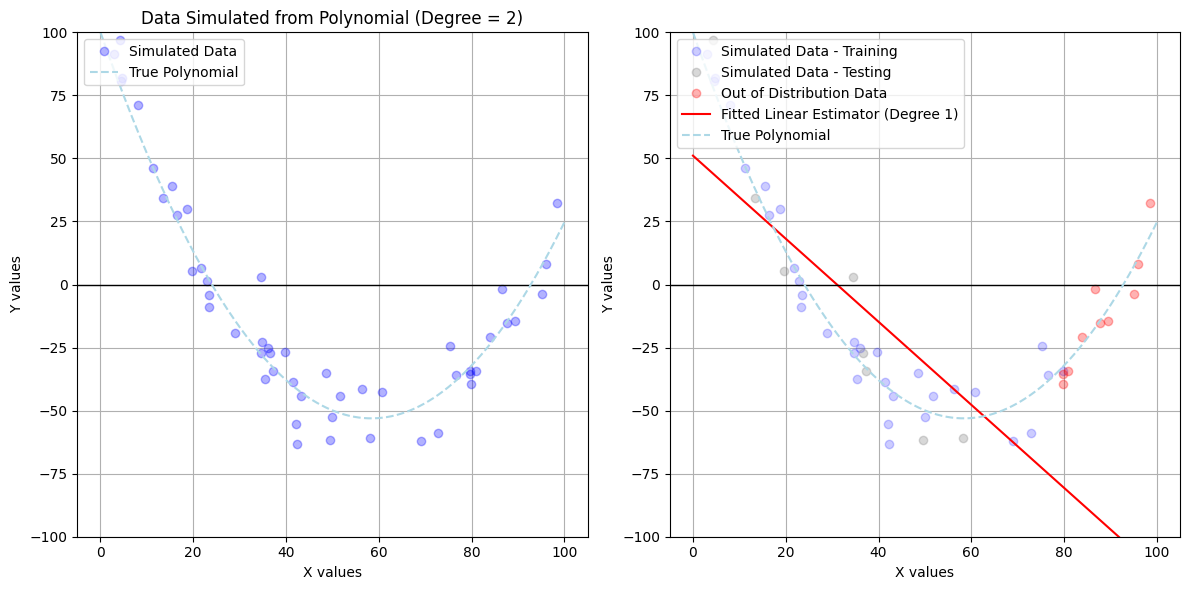

In [23]:

sim_data_df, polynomial_dict = simulate_data_from_polynomial_w_noise(poly_degree=2, noise_var = 150 , sample_size=50)
metrics, estimator_info = polynomial_regression_with_metrics(sim_data_df, 'X', 'y', estimator_degree=1)
plot_sim_poly_data_estimator(sim_data_df, polynomial_dict, estimator_info)
metrics

In [24]:
avg_MSE_ratios = []
avg_test_MSEs = []
avg_OOD_MSEs = []
sample_sizes = []
poly_orders = []
est_orders = []

for poly_order in [1,2,3, 5]:
    for est_order in [1,2,3, 5, 10]:
        for sample_size in [25,50, 75]:
            print(f"Poly Order: {poly_order} Est Order: {est_order} Sample Size: {sample_size}")

            MSE_ratios = [] 
            test_MSEs = []
            OOD_MSEs = []
            for sim in range(1000):
                sim_data_df, polynomial_dict = simulate_data_from_polynomial_w_noise(poly_degree=poly_order, noise_var = 150 , sample_size=sample_size)
                metrics, estimator_info = polynomial_regression_with_metrics(sim_data_df, 'X', 'y', estimator_degree=est_order)
                MSE_ratios.append(metrics['MSE_ratio_test_train'])
                test_MSEs.append(metrics['MSE_test'])
                OOD_MSEs.append(metrics['MSE_out_of_distribution'])

            avg_MSE_ratios.append( np.median(MSE_ratios) )
            avg_test_MSEs.append( np.median(test_MSEs) )
            avg_OOD_MSEs.append( np.median(OOD_MSEs) )
            
            poly_orders.append(poly_order); est_orders.append(est_order); sample_sizes.append(sample_size)

            # Save last fig
            fig = plot_sim_poly_data_estimator(sim_data_df, polynomial_dict, estimator_info)
            figname = f'simdata_poly_{poly_order}_est_{est_order}_samples_{sample_size}.png'
            fig.savefig(os.path.join('output', figname))
            plt.close()


Poly Order: 1 Est Order: 1 Sample Size: 25
Poly Order: 1 Est Order: 1 Sample Size: 50
Poly Order: 1 Est Order: 1 Sample Size: 75
Poly Order: 1 Est Order: 2 Sample Size: 25
Poly Order: 1 Est Order: 2 Sample Size: 50
Poly Order: 1 Est Order: 2 Sample Size: 75
Poly Order: 1 Est Order: 3 Sample Size: 25
Poly Order: 1 Est Order: 3 Sample Size: 50
Poly Order: 1 Est Order: 3 Sample Size: 75
Poly Order: 1 Est Order: 5 Sample Size: 25
Poly Order: 1 Est Order: 5 Sample Size: 50
Poly Order: 1 Est Order: 5 Sample Size: 75
Poly Order: 1 Est Order: 10 Sample Size: 25
Poly Order: 1 Est Order: 10 Sample Size: 50
Poly Order: 1 Est Order: 10 Sample Size: 75
Poly Order: 2 Est Order: 1 Sample Size: 25
Poly Order: 2 Est Order: 1 Sample Size: 50
Poly Order: 2 Est Order: 1 Sample Size: 75
Poly Order: 2 Est Order: 2 Sample Size: 25
Poly Order: 2 Est Order: 2 Sample Size: 50
Poly Order: 2 Est Order: 2 Sample Size: 75
Poly Order: 2 Est Order: 3 Sample Size: 25
Poly Order: 2 Est Order: 3 Sample Size: 50
Poly Ord

In [25]:
results = pd.DataFrame( {'poly_order':poly_orders, 'est_order':est_orders, 
                         'sample_size':sample_sizes, 'avg_MSE_ratio':avg_MSE_ratios, 
                         'avg_test_MSE':avg_test_MSEs, 'avg_OOD_MSE':avg_OOD_MSEs})
results

,poly_order,est_order,sample_size,avg_MSE_ratio,avg_test_MSE,avg_OOD_MSE
0,1,1,25,1.121592,141.706765,1.722266e+02
1,1,1,50,1.059282,148.567731,1.642119e+02
2,1,1,75,1.018926,145.150823,1.587370e+02
3,1,2,25,1.306200,148.205759,2.516762e+02
4,1,2,50,1.093178,146.070866,2.108529e+02
5,1,2,75,1.075135,150.433599,1.911766e+02
6,1,3,25,1.611290,169.571600,7.634836e+02
7,1,3,50,1.195691,152.418367,3.949421e+02
8,1,3,75,1.171728,157.191504,3.033706e+02
9,1,5,25,2.401941,205.590646,2.182940e+04


In [26]:
def plot_3d_results(results, color_var, color_lab, title, aspect_x=1, aspect_y=2, aspect_z=1):

    # Assuming your DataFrame is named `results` and has the required columns
    fig = px.scatter_3d(
        results,
        x='poly_order',
        y='est_order',
        z='sample_size',
        color=color_var,
        size=color_var,
        color_continuous_scale='rdylgn_r',
        title=title,
        labels={
            "poly_order": "Poly Order",
            "est_order": "Estimation Order",
            "sample_size": "Sample Size",
            color_var:color_lab
        }
    )

    # Customize layout for better appearance
    fig.update_traces(marker=dict(opacity=0.8))
    fig.update_layout(
        scene=dict(
            xaxis_title="Poly Order",
            yaxis_title="Estimation Order",
            zaxis_title="Sample Size",
            aspectratio=dict(x=aspect_x,y=aspect_y,z=aspect_z),
            camera=dict( eye=dict(x=3, y=2, z=2) )
        ),
        coloraxis_colorbar=dict(title=color_lab)
        ,
            width=1100,
            height=800
    )

    add_plane=True
    if add_plane:
        x = np.linspace(0,5,10)
        z = np.linspace(results['sample_size'].min(), results['sample_size'].max(),10)
        x, z = np.meshgrid(x,z)
        y=x 
        plane_surface = go.Surface(
            x=x,
            y=y,
            z=z,
            opacity=.2,
            colorscale=[[0,'green'], [1, 'green']],
            showscale=False,
            hoverinfo='skip',
            name='Properly Specified Estimators'
        )
        fig.add_trace(plane_surface)

        fig.update_layout(legend=dict(itemsizing='constant'))
    # Show the interactive plot
    fig.show()

plot_3d_results(results, 'avg_MSE_ratio' , 'Median Test/Train MSE Ratio', 'Factors that impact Test/Train MSE Ratio (Overfitting)')

In [27]:
plot_3d_results(results, 'avg_test_MSE' , 'Median Test MSE', 'Factors that impact Test Performance (Underfitting/Overfitting)')

In [28]:
results['log_avg_OOD_MSE'] = np.log10(results['avg_OOD_MSE'])
results_temp = results[results['est_order']<10]
plot_3d_results(results_temp, 'log_avg_OOD_MSE' , 'Median Log(Out of Distribution MSE)', 'Factors that impact Out of Distribution Performance (Generalizability)', aspect_y=1)